## Резюме исследования

**Заголовок:** Исследование объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.

**Вводная информация проекта:** По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

**Цель исследования:** Выявить закономерности и факторы, определяющие рыночную цену объекта недвижимости.

**Ход исследования:**
* Загрузка датасета и анализ общей информации
* Предобработка данных: выявление дубликатов, замена пропущенных значений, корректировка типов данных
* Исследовательский анализ данных: анализ сроков продажи квартир, анализ факторов, влияющих на общую (полную) стоимость объекта, анализ средней цены одного квадратного метра, анализ средней стоимости квартир на разном удалении от центра
* Тестирование гипотез

**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций

In [175]:
# Импортируем библиотеки

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.io as pio

# Правильная настройка рендерера для Colab
pio.renderers.default = 'colab'

pd.set_option('display.max_columns', None) # Настроим отображение всех колонок для наглядности

# Устанавливаем размер для всех графиков
plt.rcParams['figure.figsize'] = (8, 6)

### Описание данных

* `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
* `balcony` — число балконов
* `ceiling_height` — высота потолков (м)
* `city_centers_nearest` — расстояние до центра города (м)
* `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
* `first_day_exposition` — дата публикации
* `floor` — этаж
* `floors_total` — всего этажей в доме
* `is_apartment` — апартаменты (булев тип)
* `kitchen_area` — площадь кухни в квадратных метрах (м²)
* `last_price` — цена на момент снятия с публикации
* `living_area` — жилая площадь в квадратных метрах (м²)
* `locality_name` — название населённого пункта
* `open_plan` — свободная планировка (булев тип)
* `parks_around_3000` — число парков в радиусе 3 км
* `parks_nearest` — расстояние до ближайшего парка (м)
* `ponds_around_3000` — число водоёмов в радиусе 3 км
* `ponds_nearest` — расстояние до ближайшего водоёма (м)
* `rooms` — число комнат
* `studio` — квартира-студия (булев тип)
* `total_area` — общая площадь квартиры в квадратных метрах (м²)
* `total_images` — число фотографий квартиры в объявлении

### Анализ общей информации

In [176]:
# Подгружаем датасет
df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

In [177]:
# Ознакомимся с данными
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [178]:
# Выведем небольшой срез на экран
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


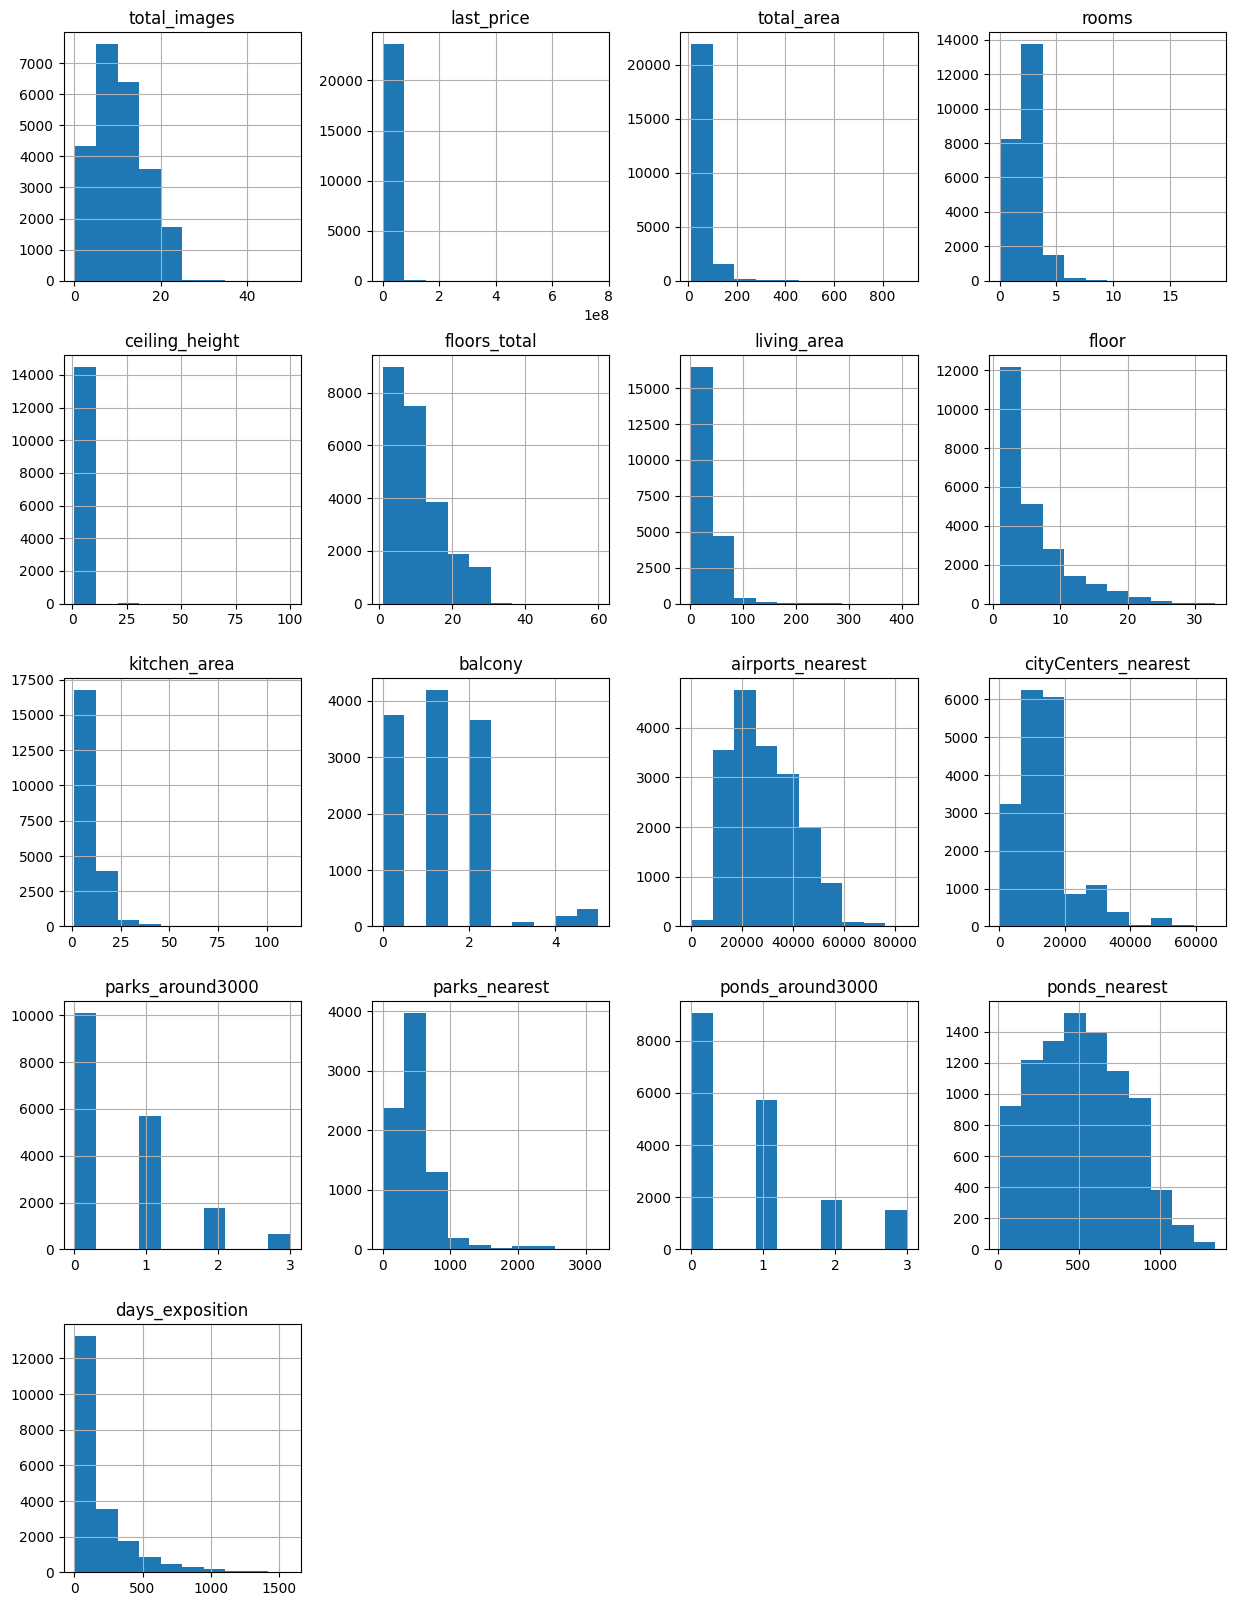

In [179]:
# Определим диапазон столбцов, выводимых на гистограмму
df_hist = df.iloc[:, np.r_[0:3, 4:10, 12:14, 15:df.shape[1]]]

# Построим гистограмму
df_hist.hist(figsize=(15,20))

# Выведем график на экран
plt.show()

#### Промежуточные выводы

* Объема датасета 23_699 строк
* В 14-ти столбцах содержатся пустые значения
* В 6-ти столбцах тип данных подлежит корректировке
* Наименование столбца `city_centers_nearest`, `parks_around_3000`, `ponds_around_3000` необходимо привести в соответствие snake_case

### Предобработка данных

#### Корректировка наименования столбца

In [180]:
# Создаем словарь для переименования столбцов
column_rename_dict = {
    'cityCenters_nearest':'city_centers_nearest',
    'parks_around3000':'parks_around_3000',
    'ponds_around3000':'ponds_around_3000'
}

# Переименуем необходимый столбец
df.rename(columns=column_rename_dict, inplace=True)

# Смотрим на результат
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around_3000', 'parks_nearest', 'ponds_around_3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

#### Анализ пропущенных значений

In [181]:
# Проверим столбцы с пустыми значениями
df.isna().sum().sort_values(ascending=False)

,0
is_apartment,20924
parks_nearest,15620
ponds_nearest,14589
balcony,11519
ceiling_height,9195
airports_nearest,5542
city_centers_nearest,5519
parks_around_3000,5518
ponds_around_3000,5518
days_exposition,3181


Проанализировав пустые значения, поступим следующим образом:

* `is_apartment` -> object (по сути булевы значения) -> заменим пустоты на 0
* `balcony` -> float -> будем считать, что это объект без балкона -> заменим пустоты на 0
* `days_exposition` -> float -> предположим, что объявление до сих пор не снято, поэтому оставим без изменений


* Дополнительно сопоставим пустоты с столбцом расстояния до ближайшего парка / водоема
    * `parks_nearest` -> float
    * `ponds_nearest` -> float


* Дополнительно сопоставим пустоты с столбцом наличия парков / водоемов
    * `parks_around_3000` -> float
    * `ponds_around_3000` -> float


* Проведем дополнительный анализ
    * `airports_nearest` -> float
    * `city_centers_nearest` -> float


* Оставим как есть за отсутствием дополнительной информации (нам неизвестны ни точный адрес зданий, ни год их постройки)
    * `ceiling_height` -> float
    * `kitchen_area`-> float
    * `living_area`-> float

##### Анализ пропущенных значений в столбцах `parks_nearest`, `parks_around_3000`

In [182]:
print('Строки с пропущенными значениями:')
print('- в столбце "parks_nearest"', df['parks_nearest'].isna().sum())
print('- в столбце "parks_around_3000"', df['parks_around_3000'].isna().sum())

print('---')

print('Строки с пропущенными значениями в обоих столбцах:',
      len(df[df['parks_nearest'].isna() & df['parks_around_3000'].isna()]))

print('Строки с пропущенными значениями в столбце "parks_nearest" и нулем в столбце "parks_around_3000":',
      len(df[(df['parks_nearest'].isna()) & (df['parks_around_3000'] == 0)]))

print('Сумма рассчитанных выше чисел',
      len(df[df['parks_nearest'].isna() & df['parks_around_3000'].isna()]) +
      len(df[(df['parks_nearest'].isna()) & (df['parks_around_3000'] == 0)]))

Строки с пропущенными значениями:
- в столбце "parks_nearest" 15620
- в столбце "parks_around_3000" 5518
---
Строки с пропущенными значениями в обоих столбцах: 5518
Строки с пропущенными значениями в столбце "parks_nearest" и нулем в столбце "parks_around_3000": 10102
Сумма рассчитанных выше чисел 15620


##### Анализ пропущенных значений в столбцах `ponds_nearest`, `ponds_around_3000`

In [183]:
print('Строки с пропущенными значениями:')
print('- в столбце "ponds_nearest"', df['ponds_nearest'].isna().sum())
print('- в столбце "ponds_around_3000"', df['ponds_around_3000'].isna().sum())

print('---')

print('Строки с пропущенными значениями в обоих столбцах:',
      len(df[df['ponds_nearest'].isna() & df['ponds_around_3000'].isna()]))

print('Строки с пропущенными значениями в столбце "ponds_nearest" и нулем в столбце "ponds_around_3000":',
      len(df[(df['ponds_nearest'].isna()) & (df['ponds_around_3000'] == 0)]))

print('Сумма рассчитанных выше чисел',
      len(df[df['ponds_nearest'].isna() & df['ponds_around_3000'].isna()]) +
      len(df[(df['ponds_nearest'].isna()) & (df['ponds_around_3000'] == 0)]))

Строки с пропущенными значениями:
- в столбце "ponds_nearest" 14589
- в столбце "ponds_around_3000" 5518
---
Строки с пропущенными значениями в обоих столбцах: 5518
Строки с пропущенными значениями в столбце "ponds_nearest" и нулем в столбце "ponds_around_3000": 9071
Сумма рассчитанных выше чисел 14589


Таким образом:
* Когда в столбце `parks_around_3000` / `ponds_around_3000` пропущены значения, в столбце `parks_nearest` / `ponds_nearest` они также не заполнены;
* Когда в столбце `parks_around_3000` / `ponds_around_3000` значения заполнены нулем, в столбце `parks_nearest` / `ponds_nearest` значения не заполнены.

Следовательно, можем обнулить пропущенные значения в столбцах `parks_around_3000` / `ponds_around_3000`

##### Анализ пропущенных значений в столбцах `airports_nearest` и `city_centers_nearest`

In [184]:
print('Строки с пропущенными значениями:')
print('- в столбце "airports_nearest"', df['airports_nearest'].isna().sum())
print('- в столбце "city_centers_nearest"', df['city_centers_nearest'].isna().sum())

print('---')

print('Строки с пропущенными значениями в обоих столбцах:',
      len(df[df['airports_nearest'].isna() & df['city_centers_nearest'].isna()]))

Строки с пропущенными значениями:
- в столбце "airports_nearest" 5542
- в столбце "city_centers_nearest" 5519
---
Строки с пропущенными значениями в обоих столбцах: 5518


Анализ показал, что если в столбце `airports_nearest` не заполнены значения, значит, они не заполнены в столбце `city_centers_nearest`.

##### Замена пустых значений на нули

In [185]:
# Создаем список столбцов для заполнения пустых значений
column_zero_list = ['is_apartment', 'balcony', 'parks_around_3000', 'ponds_around_3000']

# Заменяем значения с помощью цикла
for column in column_zero_list:
    df[column].fillna(0, inplace=True)
print('Замена проведена')

# Смотрим на результат
df.isna().sum().sort_values(ascending=False)

Замена проведена


/tmp/ipython-input-185-1350816139.py:6: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,0
parks_nearest,15620
ponds_nearest,14589
ceiling_height,9195
airports_nearest,5542
city_centers_nearest,5519
days_exposition,3181
kitchen_area,2278
living_area,1903
floors_total,86
locality_name,49


##### Замена пропущенных значений в столбцах на индикатор -1

##### Анализ пропущенных значений в столбце `locality_name`

Т.к. строк с пропущенными значениями по этому столбцу всего 49, можем их удалить.

In [186]:
df.dropna(subset=['locality_name'], inplace=True)

In [187]:
# Смотрим на результат
df.isna().sum().sort_values(ascending=False)

,0
parks_nearest,15586
ponds_nearest,14565
ceiling_height,9160
airports_nearest,5534
city_centers_nearest,5511
days_exposition,3180
kitchen_area,2269
living_area,1898
floors_total,85
rooms,0


#### Анализ дубликатов

##### Анализ явных дубликатов

In [188]:
# Посмотрим на наличие явных дубликатов
df.duplicated().sum()

np.int64(0)

Явных дубликатов нет, перейдём к неявным

##### Анализ неявных дубликатов в столбце `locality_name`

In [189]:
# Выведем количество уникальных значений
print(df['locality_name'].nunique(), '---', sep='\n')

# Посмотрим на уникальные значения в столбце
print(df['locality_name'].unique())

364
---
['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Н

In [190]:
# Замена ё на е
df.replace({'locality_name': {'ё':'е'}}, inplace=True, regex=True)

In [191]:
# Создаем временный столбец с типом населенного пункта
locality_types = df['locality_name'].str.extract(r'(^[а-яё]+(?:\s[а-яё]+)*)', expand=False).dropna().unique().tolist()

# Выведем уникальные значения
locality_types

['поселок',
 'городской поселок',
 'деревня',
 'поселок городского типа',
 'садовое товарищество',
 'село',
 'поселок городского типа имени',
 'поселок станции',
 'садоводческое некоммерческое товарищество',
 'поселок при железнодорожной станции',
 'коттеджный поселок']

In [192]:
# Создаем словарь замен
locality_dict = {
    'городской поселок':'поселок',
    'поселок городского типа':'поселок',
    'поселок станции':'поселок',
    'поселок при железнодорожной станции':'поселок',
    'коттеджный поселок':'поселок',
    'садоводческое некоммерческое товарищество':'товарищество',
    'садовое товарищество':'товарищество'
}

# Проводим замены
df['locality_name'] = df['locality_name'].replace(locality_dict, regex=True)

In [193]:
# Проверяем замены
locality_types = df['locality_name'].str.extract(r'(^[а-яё]+(?:\s[а-яё]+)*)', expand=False).dropna().unique().tolist()

# Выведем уникальные значения
print(locality_types)

# Посмотрим на уникальные значения в столбце после замен
print(df['locality_name'].nunique())

['поселок', 'деревня', 'товарищество', 'село', 'поселок имени']
318


Успешно оптимизировано 46 неявных дубликатов - имён населенных пунктов

#### Изменение типа данных в столбцах

В столбце с датой нужен соответствующий тип:
* `first_day_exposition` -> datetime

Заменим булев тип на числовой для удобства проведения анализа:
* `studio` -> int
* `open_plan` -> int
* `is_apartment` -> int

Вряд ли в столбцах ниже может быть нецелое количество парков и водоемов поблизости:
* `parks_around_3000` -> int
* `ponds_around_3000` -> int

In [194]:
# Корректируем тип данных для столбца с датой
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'])

# Корректируем тип данных для столбцов с числовыми значениями при помощи цикла
column_list = ['studio', 'open_plan', 'is_apartment', 'parks_around_3000', 'ponds_around_3000']

for column in column_list:
    df[column] = df[column].astype('int')
    print(f'тип данных в столбце {column}: {df[column].dtype}')

тип данных в столбце studio: int64
тип данных в столбце open_plan: int64
тип данных в столбце is_apartment: int64
тип данных в столбце parks_around_3000: int64
тип данных в столбце ponds_around_3000: int64


In [195]:
# Проверяем тип ланных
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  float64       
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        14490 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           21752 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  int64         
 10  studio                23650 non-null  int64         
 11  open_plan             23650 non-null  int64         
 12  kitchen_area          21381 non-null  float64       
 13  balcony              

In [196]:
# Скорректируем порядок столбцов для визуального удобства
df = df[['locality_name','total_area','living_area','kitchen_area','rooms',
         'ceiling_height','balcony','floor','floors_total','is_apartment','studio','open_plan',
         'last_price','first_day_exposition','days_exposition','total_images',
         'airports_nearest','city_centers_nearest',
         'parks_around_3000','parks_nearest','ponds_around_3000','ponds_nearest'
        ]]

# Выведем результат
df.head()

,locality_name,total_area,living_area,kitchen_area,rooms,ceiling_height,balcony,floor,floors_total,is_apartment,studio,open_plan,last_price,first_day_exposition,days_exposition,total_images,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest
0,Санкт-Петербург,108.0,51.0,25.0,3,2.70,0.0,8,16.0,0,0,0,13000000.0,2019-03-07,NaN,20,18863.0,16028.0,1,482.0,2,755.0
1,поселок Шушары,40.4,18.6,11.0,1,NaN,2.0,1,11.0,0,0,0,3350000.0,2018-12-04,81.0,7,12817.0,18603.0,0,NaN,0,NaN
2,Санкт-Петербург,56.0,34.3,8.3,2,NaN,0.0,4,5.0,0,0,0,5196000.0,2015-08-20,558.0,10,21741.0,13933.0,1,90.0,2,574.0
3,Санкт-Петербург,159.0,NaN,NaN,3,NaN,0.0,9,14.0,0,0,0,64900000.0,2015-07-24,424.0,0,28098.0,6800.0,2,84.0,3,234.0
4,Санкт-Петербург,100.0,32.0,41.0,2,3.03,0.0,13,14.0,0,0,0,10000000.0,2018-06-19,121.0,2,31856.0,8098.0,2,112.0,1,48.0


#### Промежуточные выводы по итогам этапа предобработки данных

1. Корректировка наименований столбцов
 - Результат: наименования 3-х столбцов приведены к виду snake_case

---
2. Анализ пропущенных значений
   - на нули заменены пропущенные значения в столбцах:
       * `is_apartment`
       * `balcony`
       * `parks_around_3000`
       * `ponds_around_3000`
       
   - оставлены без изменения пропущенные значения в столбцах:
       * За отсутствием возможности заполнить пустоты корректной информацией:
           * `kitchen_area`
           * `living_area`
           * `parks_nearest`
           * `ponds_nearest`
           * `airports_nearest`
           * `city_centers_nearest`
           * `ceiling_height`
           * `floors_total`
       * Пустые значения в столбце `days_exposition` означают актуальность объявления на момент выгрузки датасета
   
---
3. Анализ дубликатов
    - явные дубликаты не найдены
    - обработано 49 неявных дубликатов по столбцу `locality_name`

---
4. Корректировка типов данных
    - по столбцу `first_day_exposition` тип данных скорректирован на datetime64[ns]
    - по следующим столбцам тип данных скорректирован на числовой int:
        * `studio`
        * `open_plan`
        * `is_apartment`
        * `parks_around_3000`
        * `ponds_around_3000`

### Добавление новых столбцов

 #### Цена одного квадратного метра `price_per_sqm`

In [197]:
# Расчитаем цену 1 кв. метра
df['price_per_sqm'] = round(df['last_price'] / df['total_area'], 2)

#### День публикации объявления (0 - понедельник, 1 - вторник и т. д.) `exposition_day`

In [198]:
df.loc[:, 'exposition_day'] = df['first_day_exposition'].dt.weekday

#### Месяц публикации объявления `exposition_month`

In [199]:
df.loc[:, 'exposition_month'] = df['first_day_exposition'].dt.month

#### Год публикации объявления `exposition_year`

In [200]:
df.loc[:, 'exposition_year'] = df['first_day_exposition'].dt.year

#### Тип этажа квартиры (значения — «первый», «последний», «другой») `floor_category`

In [201]:
# Напишем функцию категоризации этажей квартиры
def floor_cat(row):
    if row['floor'] == row['floors_total']:
        return 'последний'
    elif row['floor'] < row['floors_total']:
        if row['floor'] == 1:
            return 'первый'
        else:
            return 'другой'
    else:
        return 'некорректный'

# Запустим функцию
df['floor_category'] = df.apply(floor_cat, axis=1)

In [202]:
# Смотрим на результат категоризации
df['floor_category'].value_counts()

,count
floor_category,
другой,17326
последний,3355
первый,2884
некорректный,85


Видим, что 85 квартир определены как некорректные - это пустые значения в столбце `floors_total`. В случае анализа квартир по категориям этажей будем фильтровать некорректные значения.

#### Расстояние до центра города в километрах

In [203]:
# Расчитаем значения нового столбца
df['city_centers_nearest_km'] = round(df['city_centers_nearest'] / 1000, 0)

#### Итоговый результат

In [204]:
# Выводим несколько строк на экран
df.head()

,locality_name,total_area,living_area,kitchen_area,rooms,ceiling_height,balcony,floor,floors_total,is_apartment,studio,open_plan,last_price,first_day_exposition,days_exposition,total_images,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,price_per_sqm,exposition_day,exposition_month,exposition_year,floor_category,city_centers_nearest_km
0,Санкт-Петербург,108.0,51.0,25.0,3,2.70,0.0,8,16.0,0,0,0,13000000.0,2019-03-07,NaN,20,18863.0,16028.0,1,482.0,2,755.0,120370.37,3,3,2019,другой,16.0
1,поселок Шушары,40.4,18.6,11.0,1,NaN,2.0,1,11.0,0,0,0,3350000.0,2018-12-04,81.0,7,12817.0,18603.0,0,NaN,0,NaN,82920.79,1,12,2018,первый,19.0
2,Санкт-Петербург,56.0,34.3,8.3,2,NaN,0.0,4,5.0,0,0,0,5196000.0,2015-08-20,558.0,10,21741.0,13933.0,1,90.0,2,574.0,92785.71,3,8,2015,другой,14.0
3,Санкт-Петербург,159.0,NaN,NaN,3,NaN,0.0,9,14.0,0,0,0,64900000.0,2015-07-24,424.0,0,28098.0,6800.0,2,84.0,3,234.0,408176.10,4,7,2015,другой,7.0
4,Санкт-Петербург,100.0,32.0,41.0,2,3.03,0.0,13,14.0,0,0,0,10000000.0,2018-06-19,121.0,2,31856.0,8098.0,2,112.0,1,48.0,100000.00,1,6,2018,другой,8.0


#### Промежуточные выводы по итогам добавления новых столбцов

В датафрейм добавлено 6 новых столбцов:
   * `price_per_sqm` - цена объекта за 1 квадратный метр
   * `exposition_day` - день недели размещения объявления о продаже объекта
   * `exposition_month` - месяц, в котором было размещено объявление
   * `exposition_year` - год размещения объявления
   * `floor_category` - тип этажа квартиры (первый, последний, другой)
   * `city_centers_nearest_km` - расстояние до центра города в километрах

### Исследовательский анализ данных

#### Изучение аномалий, построение гистограмм по определенным столбцам

##### Общая площадь `total_area`

In [205]:
# Посмотрим на распределение значений
df['total_area'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,total_area
count,23650.000000
mean,60.329069
std,35.661808
min,12.000000
25%,40.000000
50%,52.000000
75%,69.700000
95%,116.000000
99%,197.557000
max,900.000000


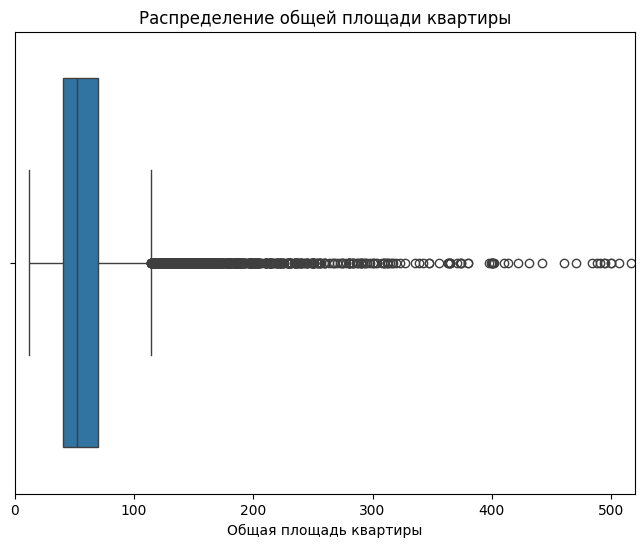

In [206]:
# Построение ящика с усами
sns.boxplot(data=df, x='total_area')
plt.title('Распределение общей площади квартиры')
plt.xlabel('Общая площадь квартиры')

# Установим предел по оси x
plt.xlim(0, 520)

plt.show()

**Промежуточные выводы:**
* Мы видим, что 99% выборки лежит в пределах 200 кв. м.
* Аномальные значения составляют от 200 до 900 кв. м.

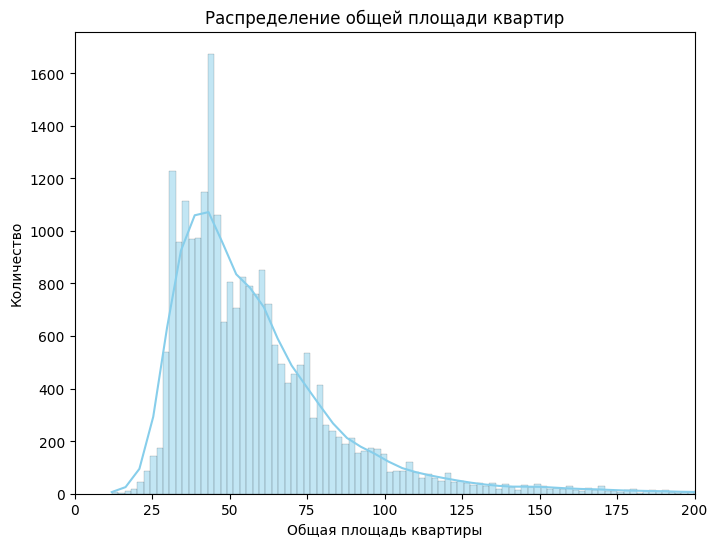

In [207]:
# Создание гистограммы
sns.histplot(data=df, x='total_area', kde=True, color='skyblue')

# Заголовок и подписи осей
plt.title('Распределение общей площади квартир')
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Количество')

# Установим предел по оси x
plt.xlim(0, 200)

plt.show()

**Выводы:** согласно графику распределение значений общей площади имеет пик в области значений от 25 до 50 кв. м, это интервал с  самыми распространенными значениями. После 50 кв. м распределение имеет тенденцию к снижению.

##### Жилая площадь `living_area`

In [208]:
# Фильтруем датафрейм по значению-индикатору и смотрим на распределение значений
df['living_area'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995])

,living_area
count,21752.000000
mean,34.448356
std,22.037664
min,2.000000
25%,18.600000
50%,30.000000
75%,42.300000
95%,69.000000
99%,120.000000
99.5%,154.171500


**Промежуточные выводы:** 99% выборки лежит в пределах до 120 кв. м, ограничим максимум этим значением для построения гисторграммы.

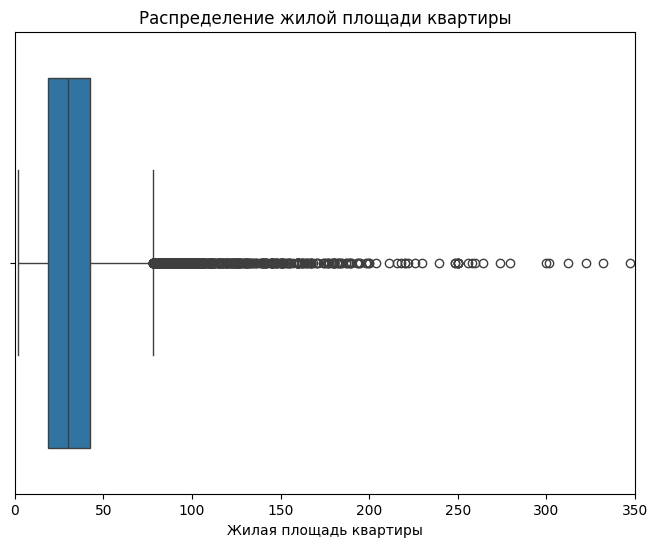

In [209]:
# Построение ящика с усами
sns.boxplot(data=df, x='living_area')
plt.title('Распределение жилой площади квартиры')
plt.xlabel('Жилая площадь квартиры')

# Установим предел по оси x
plt.xlim(0, 350)

plt.show()

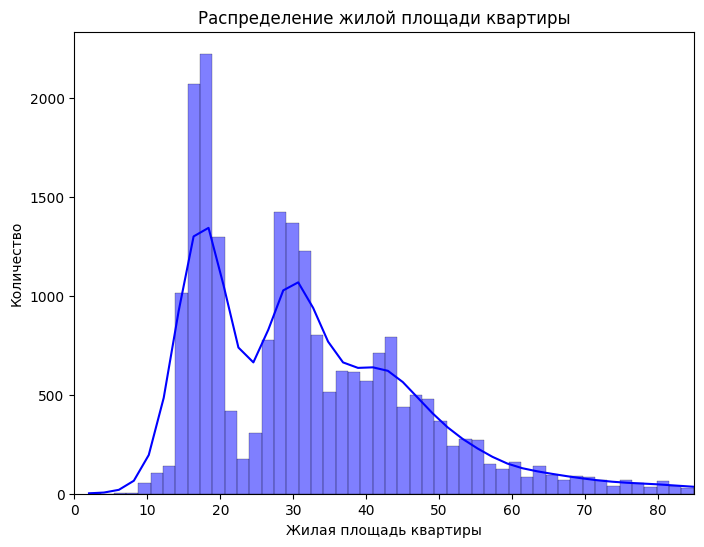

In [210]:
# Создание гистограммы
sns.histplot(data=df, x='living_area', kde=True, color='blue')

# Заголовок и подписи осей
plt.title('Распределение жилой площади квартиры')
plt.xlabel('Жилая площадь квартиры')
plt.ylabel('Количество')

# Установим предел по оси x
plt.xlim(0, 85)

plt.show()

**Выводы:** согласно графику распределение значений жилой площади имеет 2 пика - в области значений от 15 до 20 кв. м и в области значений от 27 до 32 кв. м, это самые распространенные значения. После 40 кв. м распределение имеет тенденцию к снижению.

##### Площадь кухни `kitchen_area`

In [211]:
# Фильтруем датафрейм по значению-индикатору и смотрим на распределение значений
df['kitchen_area'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995, 0.997])

,kitchen_area
count,21381.000000
mean,10.566403
std,5.901753
min,1.300000
25%,7.000000
50%,9.100000
75%,12.000000
95%,20.000000
99%,35.060000
99.5%,42.400000


**Промежуточные выводы:** 99% выборки лежит в пределах до 35 кв. м, ограничим максимум этим значением для построения гисторграммы.

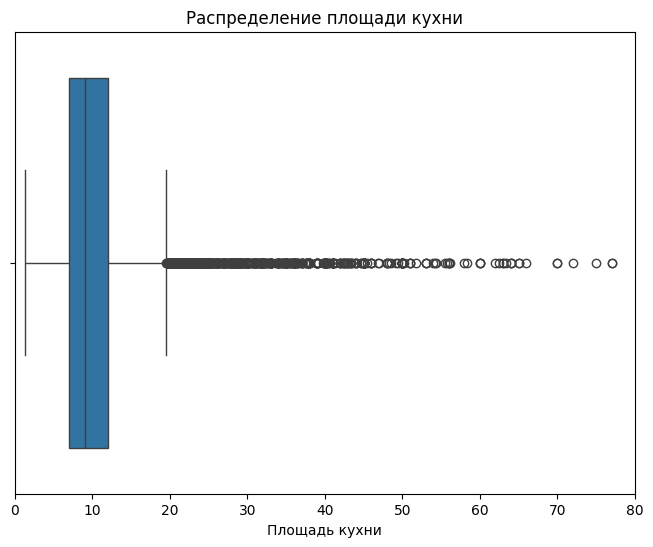

In [212]:
# Построение ящика с усами
sns.boxplot(data=df, x='kitchen_area')
plt.title('Распределение площади кухни')
plt.xlabel('Площадь кухни')

# Установим предел по оси x
plt.xlim(0, 80)

plt.show()

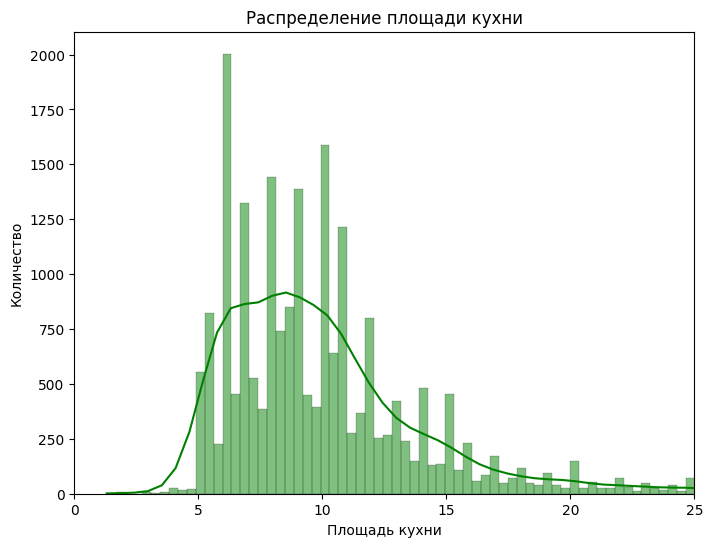

In [213]:
# Создание гистограммы
sns.histplot(data=df, x='kitchen_area', kde=True, color='green')

# Заголовок и подписи осей
plt.title('Распределение площади кухни')
plt.xlabel('Площадь кухни')
plt.ylabel('Количество')

# Установим предел по оси x
plt.xlim(0, 25)

plt.show()

**Выводы:** согласно графику распределение значений площади кухни имеет пик в области значений от 7 до 10 кв. м, это самые распространенные значения. После 10 кв. м распределение имеет тенденцию к снижению.

##### Цена объекта `last_price`

In [214]:
# Посмотрим на распределение значений
df['last_price'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,last_price
count,2.365000e+04
mean,6.541127e+06
std,1.089640e+07
min,1.219000e+04
25%,3.400000e+06
50%,4.650000e+06
75%,6.799000e+06
95%,1.530000e+07
99%,3.600000e+07
max,7.630000e+08


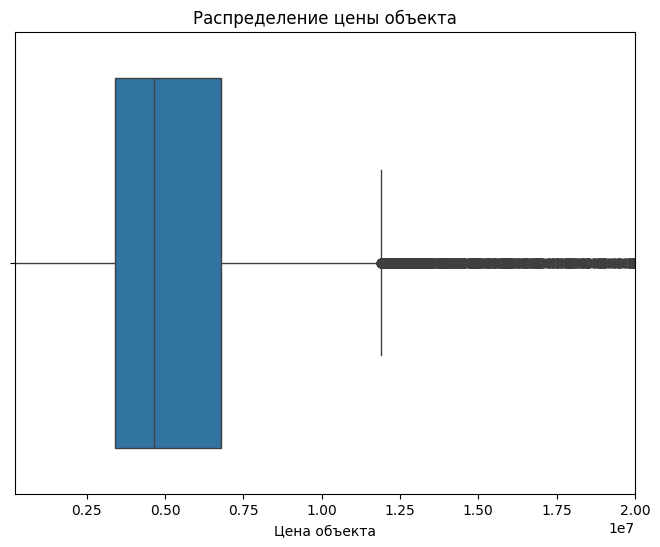

In [215]:
# Построение ящика с усами
sns.boxplot(data=df, x='last_price')
plt.title('Распределение цены объекта')
plt.xlabel('Цена объекта')

# Установим предел по оси x
plt.xlim(200_000, 20_000_000)

plt.show()

**Промежуточные выводы:** 99% выборки лежит в пределах от 11 тыс.руб. до 36_000 тыс.руб., ограничим минимум и максимум этими значениями для построения гисторграммы.

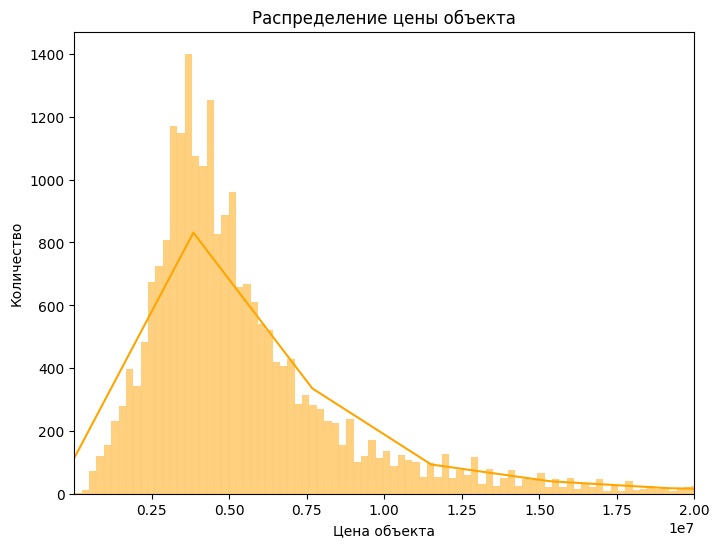

In [216]:
# Создание гистограммы
sns.histplot(data=df, x='last_price', kde=True, color='orange')

# Заголовок и подписи осей
plt.title('Распределение цены объекта')
plt.xlabel('Цена объекта')
plt.ylabel('Количество')

# Установим предел по оси x
plt.xlim(11_000, 20_000_000)

plt.show()

**Выводы:** согласно графику распределение значений цены объекта имеет пик в области 4 млн.руб., это самое распространенное значение. После этого значения распределение имеет тенденцию к снижению.

##### Количество комнат `rooms`

In [217]:
# Посмотрим на распределение значений
df['rooms'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,rooms
count,23650.000000
mean,2.070106
std,1.078620
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
95%,4.000000
99%,5.000000
max,19.000000


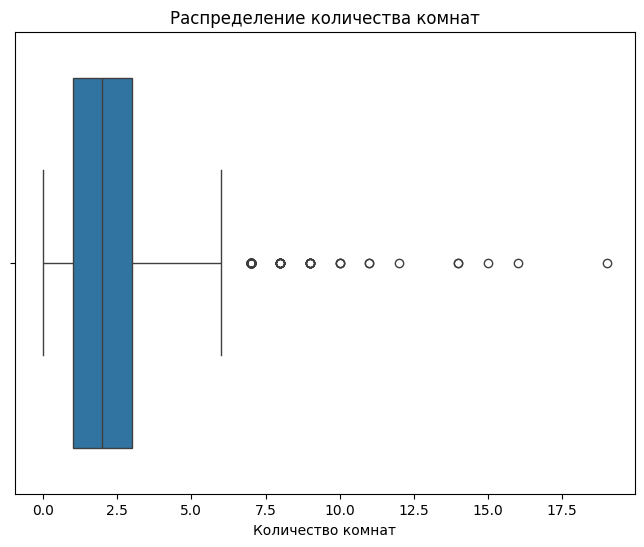

In [218]:
# Построение ящика с усами
sns.boxplot(data=df, x='rooms')
plt.title('Распределение количества комнат')
plt.xlabel('Количество комнат')
plt.show()

**Промежуточные выводы:** 99% выборки лежит в пределах до 5 комнат, ограничим максимум этим значением для построения гисторграммы. Минимум определим по значению 1.

In [219]:
# Группируем данные
df_rooms = df.groupby('rooms').size().reset_index().rename(columns={0: 'rooms_count'})

# Выводим результат
df_rooms

,rooms,rooms_count
0,0,197
1,1,8036
2,2,7924
3,3,5797
4,4,1175
5,5,326
6,6,105
7,7,59
8,8,12
9,9,8


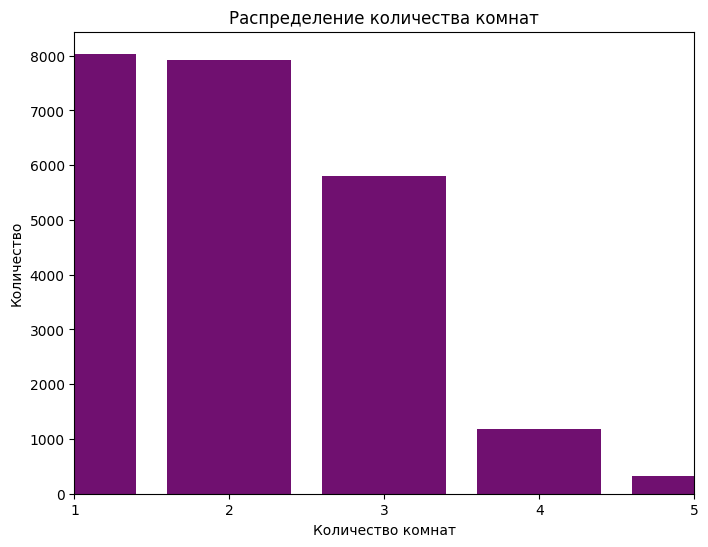

In [220]:
# Создание гистограммы
sns.barplot(data=df_rooms, x='rooms', y='rooms_count', color='purple')

# Заголовок и подписи осей
plt.title('Распределение количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество')

# Установим предел по оси x
plt.xlim(1, 5)

plt.show()

**Выводы:** согласно графику распределение значений количества комнат имеет 2 пика - в области значений 1 и 2, это самые распространенные значения. После значения 2 распределение имеет тенденцию к снижению.

##### Высота потолков `ceiling_height`

In [221]:
# Посмотрим на распределение значений
df['ceiling_height'].dropna().describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995, 0.997, 0.999])

,ceiling_height
count,14490.000000
mean,2.771287
std,1.261593
min,1.000000
25%,2.520000
50%,2.650000
75%,2.800000
95%,3.300000
99%,3.821100
99.5%,4.100000


In [222]:
# Посмотрим на высоту потолков, которая превышает 4.5 метра
df.query('ceiling_height > 4.5')['ceiling_height'].value_counts()

,count
ceiling_height,
27.00,8
25.00,7
8.00,3
5.30,2
32.00,2
4.70,2
5.00,1
5.20,1
4.80,1


In [223]:
# Разделим значения, которые превышают 20 метров, на 10
df.loc[df['ceiling_height'] >= 20, 'ceiling_height'] /= 10

# Снова посмотрим на высоту потолков, которая превышает 4.5 метра
df.query('ceiling_height > 4.5')['ceiling_height'].value_counts()

,count
ceiling_height,
8.00,3
5.30,2
4.70,2
5.20,1
5.00,1
5.60,1
4.80,1
8.30,1
5.50,1


In [224]:
# Снова посмотрим на распределение значений
df['ceiling_height'].dropna().describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995, 0.997, 0.999])

,ceiling_height
count,14490.000000
mean,2.729355
std,0.319691
min,1.000000
25%,2.510000
50%,2.650000
75%,2.800000
95%,3.285500
99%,3.780000
99.5%,4.000000


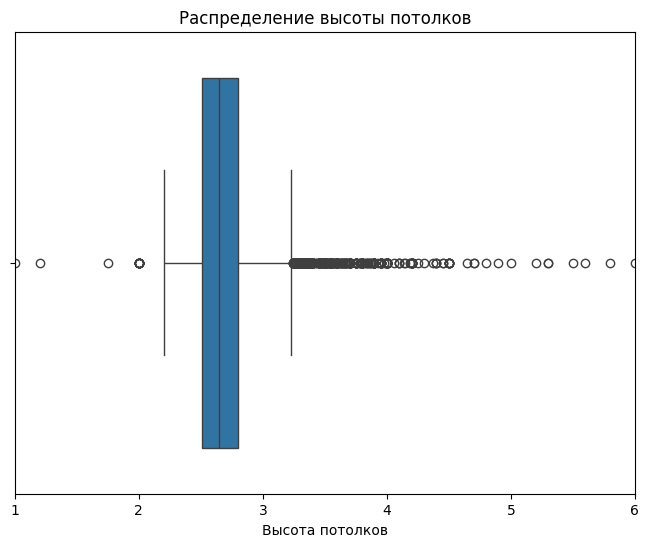

In [225]:
# Построение ящика с усами
sns.boxplot(data=df, x='ceiling_height')
plt.title('Распределение высоты потолков')
plt.xlabel('Высота потолков')

# Установим предел по оси x
plt.xlim(1, 6)

plt.show()

**Промежуточные выводы:** 99% выборки лежит в пределах до 5.1 м, ограничим максимум этим значением для построения гисторграммы. Минимум определим по значению 2.

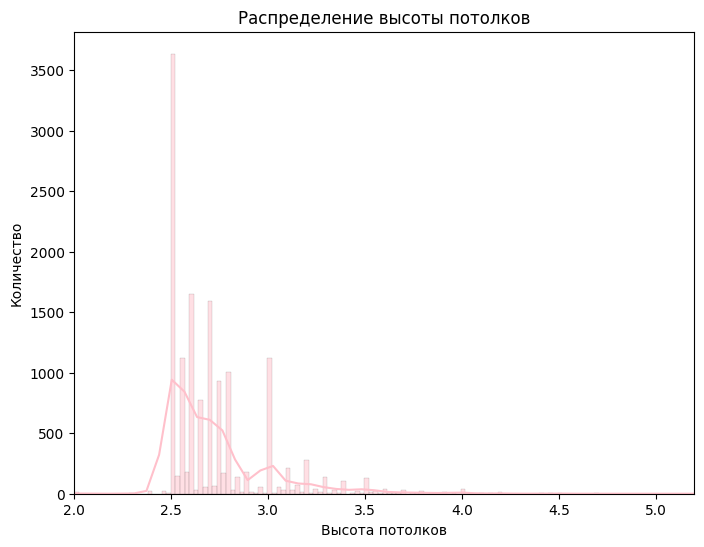

In [226]:
# Создание гистограммы
sns.histplot(data=df, x='ceiling_height', kde=True, color='pink')

# Заголовок и подписи осей
plt.title('Распределение высоты потолков')
plt.xlabel('Высота потолков')
plt.ylabel('Количество')

# Установим предел по оси x
plt.xlim(2, 5.2)

plt.show()

**Выводы:** согласно графику распределение значений высоты потолков имеет пик в области 2.5 метров, это самое распространенное значение, после которого распределение имеет тенденцию к снижению.

##### Тип этажа квартиры («первый», «последний», «другой») `floor_category`

In [227]:
# Группируем данные
df_floor_cat = df.groupby('floor_category').size().reset_index().rename(columns={0: 'floor_category_count'})

# Отфильтруем данные от некорректных значений
filtered_df_floor_cat = df_floor_cat[df_floor_cat['floor_category'] != 'некорректный']

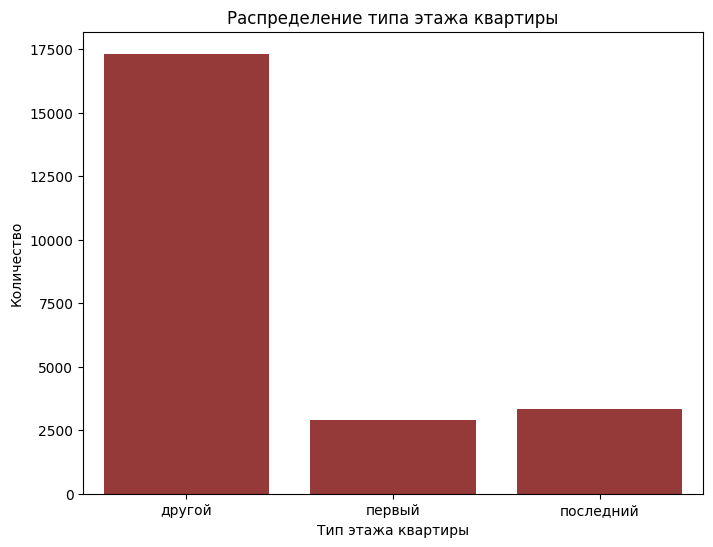

In [228]:
# Создание гистограммы
sns.barplot(data=filtered_df_floor_cat, x='floor_category', y='floor_category_count', color='brown')

# Заголовок и подписи осей
plt.title('Распределение типа этажа квартиры')
plt.xlabel('Тип этажа квартиры')
plt.ylabel('Количество')

plt.show()

**Выводы:** согласно графику распределение значений типа этажа квартиры имеет пик в категории "другой" (то есть, не первый и не последний этаж), это самое распространенная категория, после которой распределение имеет тенденцию к снижению.

##### Общее количество этажей в доме `floors_total`

In [229]:
# Посмотрим на распределение значений
df['floors_total'].dropna().describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995, 0.997])

,floors_total
count,23565.000000
mean,10.675875
std,6.594823
min,1.000000
25%,5.000000
50%,9.000000
75%,16.000000
95%,25.000000
99%,26.000000
99.5%,27.000000


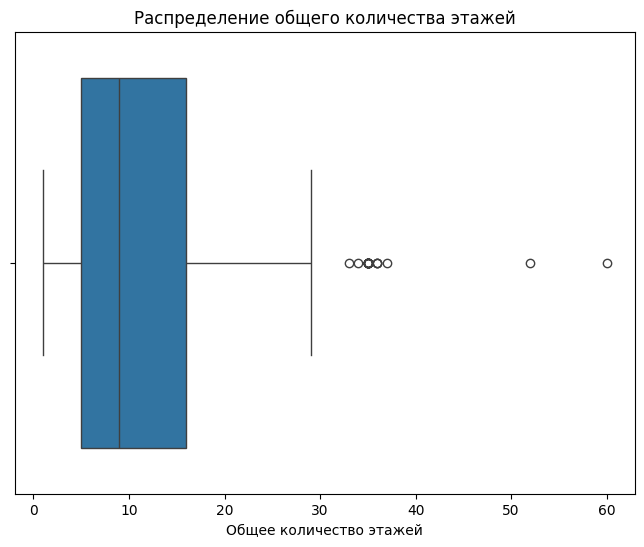

In [230]:
# Построение ящика с усами
sns.boxplot(data=df, x='floors_total')
plt.title('Распределение общего количества этажей')
plt.xlabel('Общее количество этажей')
plt.show()

**Промежуточные выводы:** 99% выборки лежит в пределах до 27 этажей, ограничим максимум с запасом до 30 для построения гисторграммы. Минимум определим по значению 1.

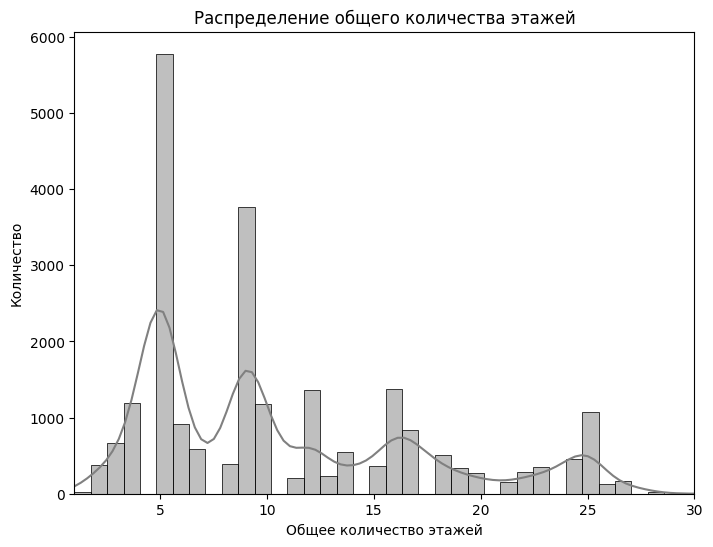

In [231]:
# Создание гистограммы
sns.histplot(data=df, x='floors_total', kde=True, color='gray')

# Заголовок и подписи осей
plt.title('Распределение общего количества этажей')
plt.xlabel('Общее количество этажей')
plt.ylabel('Количество')

# Установим предел по оси x
plt.xlim(1, 30)

plt.show()

**Выводы:** согласно графику распределение значений общего количества этажей имеет пик в значении 5 (самое распространенное количество этажей), после которого распределение имеет тенденцию к снижению.

##### Расстояние до центра города в метрах `city_centers_nearest`

In [232]:
# Посмотрим на распределение значений
df['city_centers_nearest'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.97, 0.99])

,city_centers_nearest
count,18139.000000
mean,14197.860742
std,8606.830295
min,181.000000
25%,9241.000000
50%,13105.000000
75%,16293.000000
95%,31651.100000
97%,34147.860000
99%,50065.860000


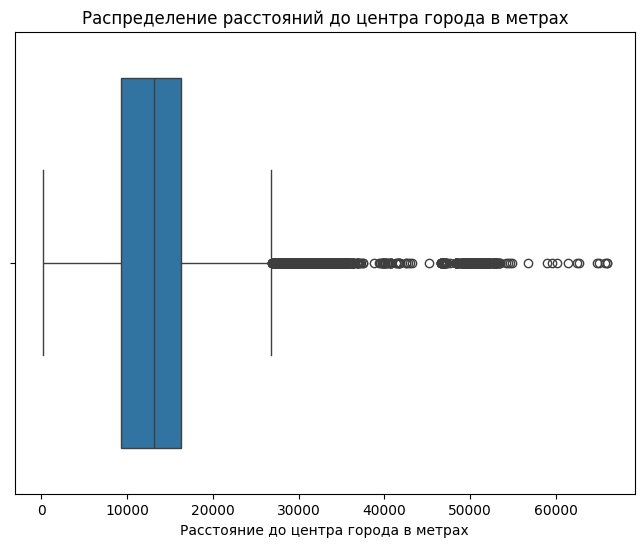

In [233]:
# Построение ящика с усами
sns.boxplot(data=df, x='city_centers_nearest')
plt.title('Распределение расстояний до центра города в метрах')
plt.xlabel('Расстояние до центра города в метрах')
plt.show()

**Промежуточные выводы:** 99% выборки лежит в пределах до 49 км, ограничим максимум этим значением для построения гисторграммы.
В данном столбце есть также значение-индикатор 0, его тоже отфильтруем.

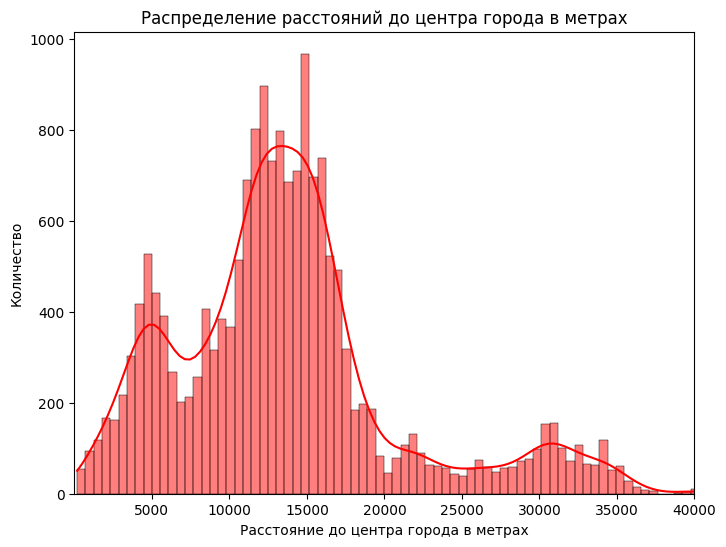

In [234]:
# Создание гистограммы
sns.histplot(data=df, x='city_centers_nearest', kde=True, color='red')

# Заголовок и подписи осей
plt.title('Распределение расстояний до центра города в метрах')
plt.xlabel('Расстояние до центра города в метрах')
plt.ylabel('Количество')

# Установим предел по оси x
plt.xlim(1, 40_000)

plt.show()

**Выводы:** согласно графику распределение значений расстояния до центра города имеет пик в пределах от 11 км до 16 км, это интервал с самыми распространенными значениями, после которых распределение имеет тенденцию к снижению.

##### Расстояние до ближайшего парка `parks_nearest`

In [235]:
# Посмотрим на распределение значений
df['parks_nearest'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,parks_nearest
count,8064.000000
mean,490.830729
std,342.554386
min,1.000000
25%,288.000000
50%,454.500000
75%,612.000000
95%,968.000000
99%,2102.000000
max,3190.000000


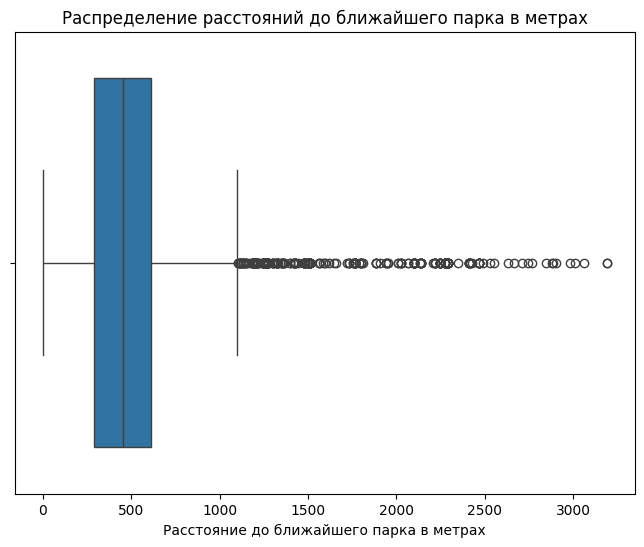

In [236]:
# Построение ящика с усами
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='parks_nearest')
plt.title('Распределение расстояний до ближайшего парка в метрах')
plt.xlabel('Расстояние до ближайшего парка в метрах')
plt.show()

**Промежуточные выводы:** 99% выборки лежит в пределах до 1270 км, ограничим максимум этим значением для построения гисторграммы.
В данном столбце есть также значение-индикатор 0, его тоже отфильтруем.

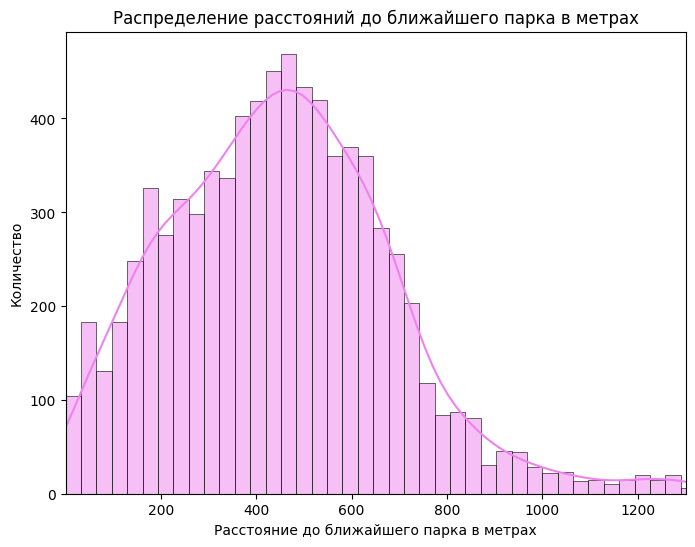

In [237]:
# Создание гистограммы
sns.histplot(data=df, x='parks_nearest', kde=True, color='violet')

# Заголовок и подписи осей
plt.title('Распределение расстояний до ближайшего парка в метрах')
plt.xlabel('Расстояние до ближайшего парка в метрах')
plt.ylabel('Количество')

# Установим предел по оси x
plt.xlim(1, 1300)

plt.show()

**Выводы:** согласно графику распределение значений расстояния до ближайшего парка имеет пик в районе 500 метров, после которого распределение имеет тенденцию к снижению.

##### Промежуточные выводы по итогам изучения гистограмм

Интервал с самыми распространенными значениями по столбцам:

* Общая площадь `total_area` 25-50 кв. м
* Жилая площадь `living_area` 15-30 кв. м
* Площадь кухни `kitchen_area` 7-10 кв. м
* Цена объекта `last_price` 4-7 млн. руб.
* Количество комнат `rooms` 1-2 комнаты

---

Самые распространенные категории / значения по столбцам:

* Высота потолков `ceiling_height` 2.5 м
* Тип этажа квартиры `floor_category` другой (не первый и не последний)
* Общее количество этажей в доме `floors_total` 5 этажей
* Расстояние до центра города в метрах `city_center_nearest` 11-16 км
* Расстояние до ближайшего парка `parks_nearest` 400-600 м

#### Анализ сроков продажи квартир

##### Построение гистограммы по данным о сроках продажи квартир

In [238]:
# Изучим распределение значений
df['days_exposition'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,days_exposition
count,20470.000000
mean,180.753200
std,219.777916
min,1.000000
25%,45.000000
50%,95.000000
75%,231.000000
95%,647.550000
99%,1069.000000
max,1580.000000


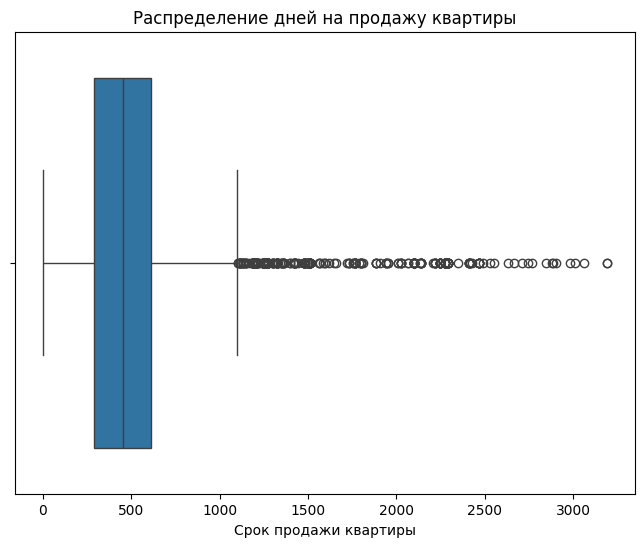

In [239]:
# Построение ящика с усами
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='parks_nearest')
plt.title('Распределение дней на продажу квартиры')
plt.xlabel('Срок продажи квартиры')
plt.show()

**Промежуточные выводы:** 99% выборки лежит в пределах до 1044 дня, однако график показывает выбросы, начиная от 750 дней. Значит, объявления в продаже более 750 дней - редкий случай для нашей выборки. Ограничим максимум этим значением для построения гисторграммы.

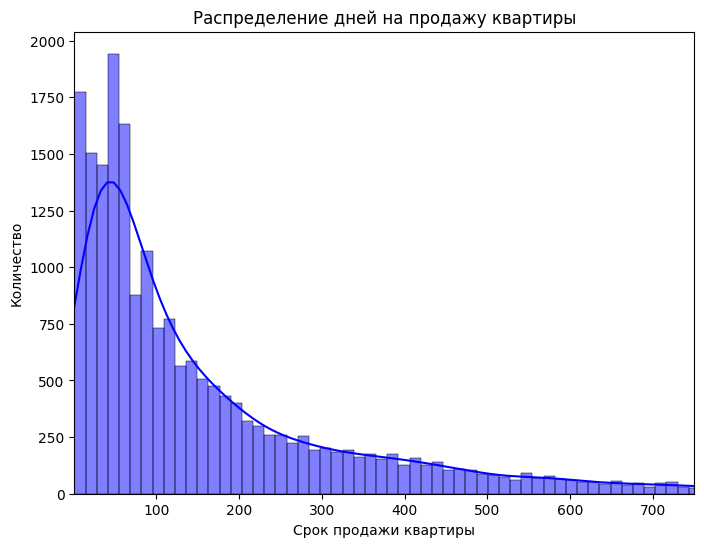

In [240]:
# Создание гистограммы
sns.histplot(data=df, x='days_exposition', kde=True, color='blue')

# Заголовок и подписи осей
plt.title('Распределение дней на продажу квартиры')
plt.xlabel('Срок продажи квартиры')
plt.ylabel('Количество')

# Установим предел по оси x
plt.xlim(1, 750)

plt.show()

**Выводы:** согласно графику распределение имеет пик в районе 80 дней, после которого распределение имеет тенденцию к снижению.

##### Расчёт среднего и медианы по данным о сроках продажи квартир

In [241]:
# Расчёт среднего и медианы произведём по отфильтрованному ранее датасету
mean_median = round(df['days_exposition'].agg({'Среднее':'mean', 'Медиана':'median'}))

# Вывод результата на экран
mean_median

,days_exposition
Среднее,181.0
Медиана,95.0


##### Выводы по итогам анализа сроков продажи квартир

1. Cогласно графику распределение сроков продажи квартир имеет пик в районе 80 дней, после которого распределение имеет тенденцию к снижению.
2. Среднее (181 день) превышает медиану (95 дней) практически в 2 раза, что объясняется наличием аномально высоких сроков продаж квартиры (от 750 дней и выше).
3. Обычно продажа квартиры составляет 95 дней. Аномально быстрым сроком продажи можно считать срок до 45 дней (первый квартиль), аномально долгими можно считать срок продажи от 231 дня (третий квартиль) и выше.

#### Анализ факторов, влияющих на общую (полную) стоимость объекта

##### Фактор - общая площадь `total_area`

In [242]:
# Построим график по сводной таблице (напомню, что 99% выборки лежит в пределах 200 кв. м)
df_area = df.query('total_area <= 200').pivot_table(index='total_area', values='last_price', aggfunc='median').reset_index()

# Выводим результат
df_area

,total_area,last_price
0,12.0,2400000.0
1,13.0,1850000.0
2,13.2,1686000.0
3,14.0,1190000.0
4,15.0,1725000.0
...,...,...
2020,198.0,30489500.0
2021,198.1,20000000.0
2022,198.9,30000000.0
2023,199.2,18924000.0


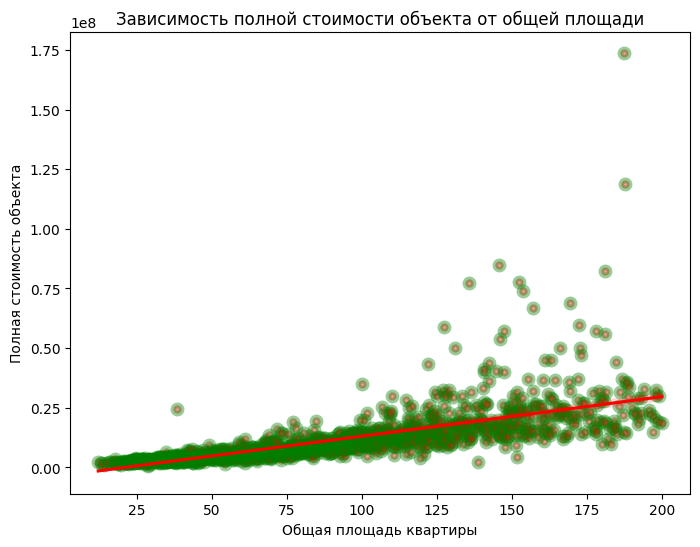

In [243]:
# Строим точечную диаграмму
plt.scatter(x=df_area['total_area'],
            y=df_area['last_price'],
            c="red",  # цвет точек (красный)
            linewidths = 4, # ширина границы точки (4)
            edgecolors = 'green', # цвет границы точки (зеленый)
            alpha = 0.4) # уровень прозрачности)
            #label="Зависимость цены от общей площади")

# Добавляем линию тренда
sns.regplot(
    x=df_area['total_area'],
    y=df_area['last_price'],
    data=df_area,
    scatter=False,
    color='red'
)

plt.title('Зависимость полной стоимости объекта от общей площади')
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Полная стоимость объекта')
plt.show()

**Выводы:** Можем утверждать, что между общей площадью и общей стоимостью объекта существует положительная корреляция - с увеличением площади растет стоимость жилья

##### Фактор - жилая площадь `living_area`

In [244]:
# Фильтруем значение-индикатор и строим сводную таблицу (напомню, что 99% выборки лежит в пределах 120 кв.м)
df_living_area_filtered = (
    df.query('living_area <= 120') \
    .pivot_table(index='living_area', values='last_price', aggfunc='median') \
    .reset_index()
)

# Выводим результат на экран
df_living_area_filtered

,living_area,last_price
0,2.0,4340000.0
1,3.0,34715000.0
2,5.0,2680000.0
3,5.4,6100000.0
4,6.0,3799000.0
...,...,...
1629,119.0,14300000.0
1630,119.3,29500000.0
1631,119.5,21800000.0
1632,119.9,18500000.0


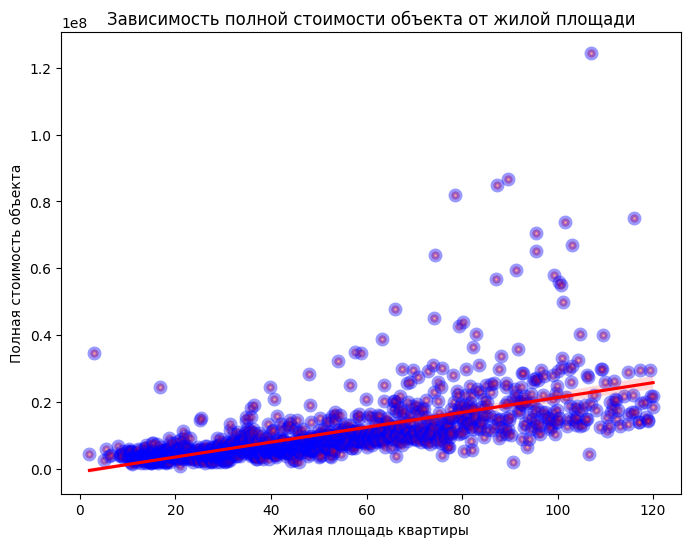

In [245]:
# Строим точечную диаграмму
plt.scatter(x=df_living_area_filtered['living_area'],
            y=df_living_area_filtered['last_price'],
            c="red",  # цвет точек (красный)
            linewidths = 4, # ширина границы точки (4)
            edgecolors = 'blue', # цвет границы точки (голубой)
            alpha = 0.4) # уровень прозрачности

# Добавляем линию тренда
sns.regplot(
    x=df_living_area_filtered['living_area'],
    y=df_living_area_filtered['last_price'],
    data=df_living_area_filtered,
    scatter=False,
    color='red'
)

plt.title('Зависимость полной стоимости объекта от жилой площади')
plt.xlabel('Жилая площадь квартиры')
plt.ylabel('Полная стоимость объекта')
plt.show()

**Выводы:**
Можем утверждать, что между жилой площадью и общей стоимостью объекта существует положительная корреляция - с увеличением жилой площади растет стоимость жилья.

##### Фактор - площадь кухни `kitchen_area`

In [246]:
# Фильтруем значение-индикатор и строим график по сводной таблице (напомню, что 99% выборки лежит в пределах 40 кв.м)
df_kitchen_area_filtered = (
    df.query('kitchen_area <= 40') \
    .pivot_table(index='kitchen_area', values='last_price', aggfunc='median') \
    .reset_index()
);

# Смотрим на результат
df_kitchen_area_filtered

,kitchen_area,last_price
0,1.30,4250000.0
1,2.00,2720000.0
2,2.30,2940000.0
3,2.40,2200000.0
4,2.89,5967734.0
...,...,...
896,39.00,16900000.0
897,39.10,54500000.0
898,39.70,10500000.0
899,39.90,19713740.0


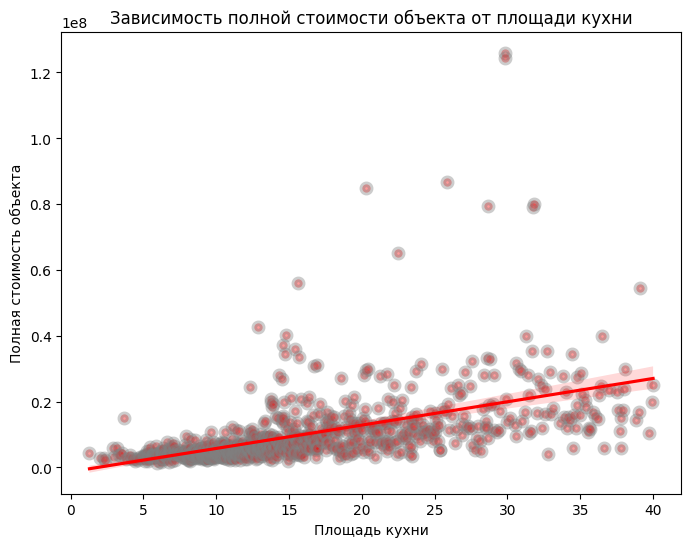

In [247]:
# Строим точечную диаграмму
plt.scatter(x=df_kitchen_area_filtered['kitchen_area'],
            y=df_kitchen_area_filtered['last_price'],
            c="red",  # цвет точек (красный)
            linewidths = 4, # ширина границы точки (4)
            edgecolors = 'gray', # цвет границы точки (серый)
            alpha = 0.4) # уровень прозрачности

# Добавляем линию тренда
sns.regplot(
    x=df_kitchen_area_filtered['kitchen_area'],
    y=df_kitchen_area_filtered['last_price'],
    data=df_kitchen_area_filtered,
    scatter=False,
    color='red'
)

plt.title('Зависимость полной стоимости объекта от площади кухни')
plt.xlabel('Площадь кухни')
plt.ylabel('Полная стоимость объекта')
plt.show()

**Выводы:**
Можем утверждать, что между площадью кухни и общей стоимостью объекта существует положительная корреляция - с увеличением площади кухни растет стоимость жилья.

##### Фактор - количество комнат `rooms`

При построении гистограммы по столбцу `rooms` мы ограничили значения в пределах от 1 до 5. Примением аналогичный подход при построении следующего графика.

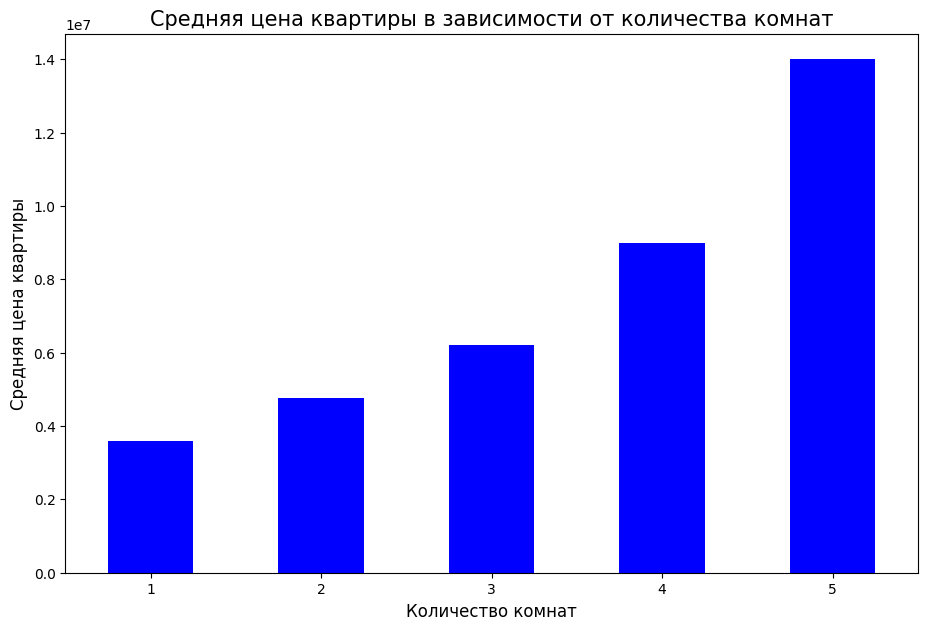

In [248]:
# Фильтруем значения (99% выборки составляют квартиры от 1 до 5 комнат)
df_rooms_filtered = df.query('rooms >= 1 and rooms <= 5')

# Построим график
df_rooms_filtered.groupby('rooms')['last_price'].median().plot(kind='bar', figsize=(11, 7), color='blue')

plt.xticks(rotation=0)
plt.title('Средняя цена квартиры в зависимости от количества комнат', size=15)
plt.xlabel('Количество комнат', size=12)
plt.ylabel('Средняя цена квартиры', size=12)

plt.show()

**Выводы:** можем утверждать, что между количеством комнат и общей стоимостью объекта существует положительная корреляция - с увеличением количества комнат растет стоимость жилья.

##### Фактор - тип этажа `floor_category`

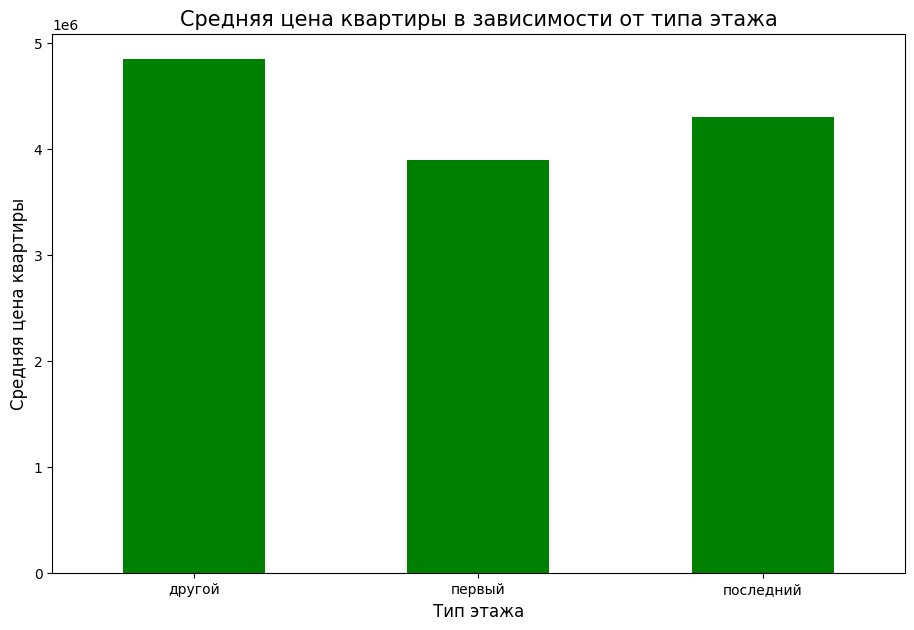

In [249]:
# Фильтруем некорректное значение - когда указанный этаж больше, чем общее количество этажей
df_floor_cat_filtered = df.query('floor_category != "некорректный"')

# Построим график
df_floor_cat_filtered.groupby('floor_category')['last_price'].median().plot(kind='bar', figsize=(11, 7), color='green')

plt.xticks(rotation=0)
plt.title('Средняя цена квартиры в зависимости от типа этажа', size=15)
plt.xlabel('Тип этажа', size=12)
plt.ylabel('Средняя цена квартиры', size=12)

plt.show()

**Выводы:**
можем утверждать, что между типом этажа и общей стоимостью объекта существует корреляция - самая высокая медиана стоимости в категории "другой".

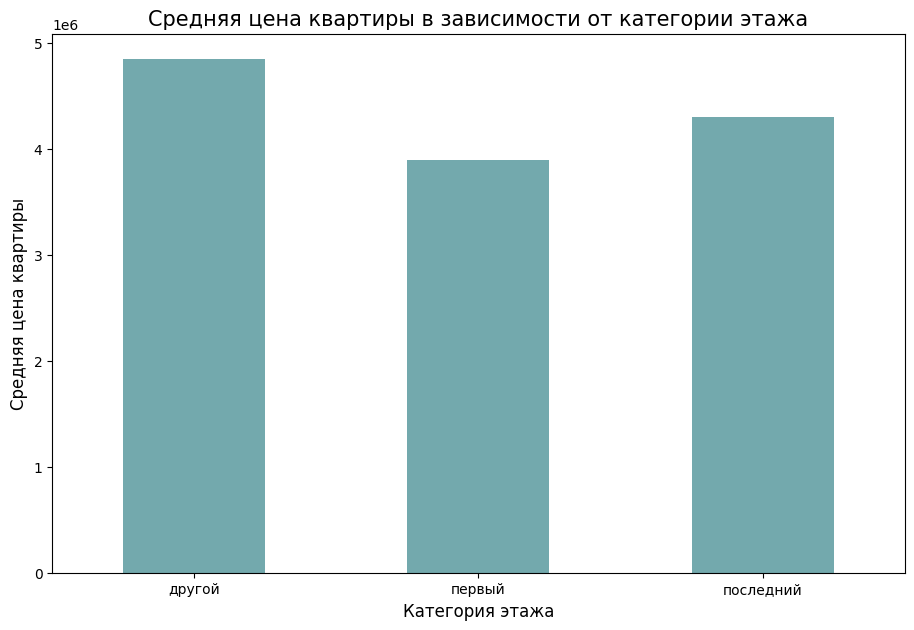

In [250]:
# код ревьюера

df_floor_cat_filtered.groupby('floor_category')['last_price'].median().plot(kind='bar', figsize=(11, 7), color='#73A9AD')

plt.xticks(rotation=0)
plt.title('Средняя цена квартиры в зависимости от категории этажа', size=15)
plt.xlabel('Категория этажа', size=12)
plt.ylabel('Средняя цена квартиры', size=12)

plt.show()

##### Фактор - дата размещения `exposition_day` / `exposition_month` / `exposition_year`

###### Фактор - год размещения `exposition_year`

In [261]:
# Группируем данные по году, расчитываем медиану цены продажи и строим график
fig = px.bar(
    data_frame=df.groupby('exposition_year')['last_price'].median().reset_index(),
    x='exposition_year',
    y='last_price',
    title='Зависимость средней стоимости квартиры от года публикации объявления',
    labels={
        'exposition_year': 'Год публикации объявления',
        'last_price': 'Средняя стоимость квартиры (млн.руб.)'
    },
    color_discrete_sequence=['orange']
)

# Выводим график
fig.show()

**Выводы:** по графику видно, что медиана стоимости жилья снижалась год к году с 2014 по 2016 гг., после чего показатель цены вышел на плато с небольшим ростом в 2019 году по отношению к 2018 году.

###### Фактор - месяц размещения `exposition_month`

In [253]:
# Группируем данные по месяцу, расчитываем медиану цены продажи и строим график
fig = px.bar(
    df.groupby('exposition_month')['last_price'].median().reset_index(),
    x='exposition_month',
    y='last_price',
    title='Зависимость средней стоимости квартиры от месяца публикации объявления',
    labels={
        'exposition_month': 'Месяц публикации объявления',
        'last_price': 'Средняя стоимость квартиры (млн.руб.)'
    },
    color_discrete_sequence=['blue']
)

# Выводим график
fig.show()

**Выводы:**
1. По графику видно, что медиана стоимости жилья достигла пикового значение в апреле.
2. Также наблюдаются локальные пиковые значения в сентябре и ноябре.
3. Самое низкое значение медианы стоимости жилья наблюдается в июне после падения средней цены, начиная с апреля.

###### Фактор - день размещения `exposition_day`

In [254]:
# Группируем данные по дню, расчитываем медиану цены продажи и строим график
fig = px.bar(
    df.groupby('exposition_day')['last_price'].median().reset_index(),
    x='exposition_day',
    y='last_price',
    title='Зависимость средней стоимости квартиры от дня публикации объявления',
    labels={
        'exposition_day': 'День публикации объявления',
        'last_price': 'Средняя стоимость квартиры (млн.руб.)'
    },
    color_discrete_sequence=['green']
)

# Выводим график
fig.show()

**Выводы:**
1. По графику видно, что медиана стоимости жилья достигает пикового значения во вторник.
2. Самое низкое значение медианы стоимости жилья наблюдается в воскресенье.
3. В целом заметна тенденция к резкому снижению медианы с вторника по воскресенье.

##### Матрица корреляции числовых значений

In [255]:
# Отфильтруем необходимые значения
df_filtered_corr = df.query('(total_area <= 200) and (living_area <= 120) and (kitchen_area <= 40)')

# Выделим необходимые столбцы
columns_matrix = ['last_price', 'total_area', 'living_area', 'kitchen_area']

# Построим матрицу корреляции
round(df_filtered_corr[columns_matrix].corr(), 2)

,last_price,total_area,living_area,kitchen_area
last_price,1.00,0.65,0.54,0.48
total_area,0.65,1.00,0.93,0.56
living_area,0.54,0.93,1.00,0.32
kitchen_area,0.48,0.56,0.32,1.00


##### Промежуточные выводы

1. Существует положительная корреляция между ценой квартиры и общей площадью (0.65 - наибольшая корреляция), жилой площадью (0.54) и площадью кухни (0.48).

2. С увеличением количества комнат средняя цена квартиры также растет.

3. Если говорить о типе этажа, то наибольшая средняя цена у квартир, расположенных не на первом и не на последнем этажах.

4. Что касается данных о дате размещения публикации:
    * в разрезе года: самая высокая средняя стоимость квартиры наблюдалась в 2014 году, самая низкая - в период с 2016 по 2018 гг.
    * в разрезе месяца: пиковое значение средней цены квартиры достигается в апреле, минимальное - в июне
    * в разрезе дня: пиковое значение достигается во вторник, минимальное - в воскресенье

#### Анализ средней цены одного квардратного метра

##### Анализ

In [256]:
# Посчитаем количество объявлений в различных регионах
top_locals = df['locality_name'].value_counts().head(10).index.tolist()

# Выводим результат
top_locals

['Санкт-Петербург',
 'поселок Мурино',
 'поселок Шушары',
 'Всеволожск',
 'Пушкин',
 'Колпино',
 'поселок Парголово',
 'Гатчина',
 'деревня Кудрово',
 'Выборг']

In [257]:
# Создаём сводную таблицу
df_top_locals = (
    df.query('locality_name in @top_locals')
    .pivot_table(index='locality_name', values='price_per_sqm', aggfunc='mean')
    .sort_values(by='price_per_sqm', ascending=False)
    .reset_index()
)

# Смотрим на результат
df_top_locals

,locality_name,price_per_sqm
0,Санкт-Петербург,114849.008793
1,Пушкин,103125.819377
2,деревня Кудрово,92473.547559
3,поселок Парголово,90175.913089
4,поселок Мурино,85681.762572
5,поселок Шушары,78677.364318
6,Колпино,75424.579112
7,Гатчина,68746.146515
8,Всеволожск,68654.473970
9,Выборг,58141.909325


##### Выводы

1. Самая высокая цена квадратного метра в:
    * Санкт-Петербурге (115 тыс.руб.)
    * Пушкине (103 тыс.руб.)
    * д. Кудрово (92 тыс.руб.)
    * поселке Парголово (90 тыс.руб.)


2. Самая низкая цена квадратного метра в:
    * Гатчине (69 тыс.руб.)
    * Всеволжске (69 тыс.руб.)
    * Выборге (58 тыс.руб.)

#### Анализ средней стоимости квартир на разном удалении от центра

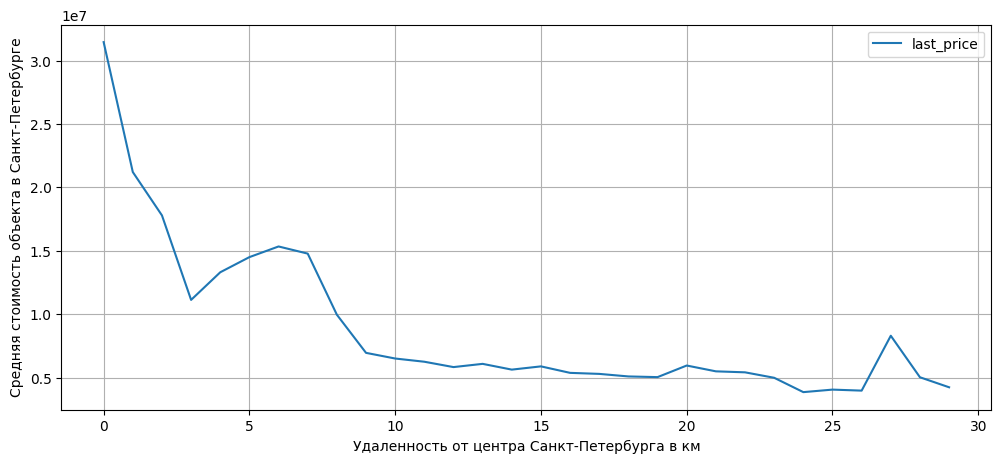

In [258]:
# Создаём сводную таблицу и рисуем график для наглядности
(
    df.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='city_centers_nearest_km', values='last_price', aggfunc='mean')
    .plot(grid=True, figsize=(12, 5), \
          xlabel='Удаленность от центра Санкт-Петербурга в км', ylabel='Средняя стоимость объекта в Санкт-Петербурге')
);

#### Промежуточные выводы

1. По графику видно, что средняя стоимость жилья достигает пикового значения, когда квартира находится непосредственно в центре города.
2. Также наблюдаются локальное пиковое значение на 6-7 км.
3. Самое низкое значение средней стоимости жилья наблюдается при достижении 25 км от центра.
4. В целом график имеет нисходящий тренд, что говорит об отрицательной корреляции показателя удаленности от центра и средней стоимости квартиры в Санкт-Петербурге - чем дальше объект от центра, тем ниже его средняя стоимость.

In [259]:
# Посмотрим подробнее на пик в районе 27 км
df.query('locality_name == "Санкт-Петербург" and city_centers_nearest_km == 27')

,locality_name,total_area,living_area,kitchen_area,rooms,ceiling_height,balcony,floor,floors_total,is_apartment,studio,open_plan,last_price,first_day_exposition,days_exposition,total_images,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,price_per_sqm,exposition_day,exposition_month,exposition_year,floor_category,city_centers_nearest_km
748,Санкт-Петербург,74.0,30.0,25.0,2,3.13,0.0,3,5.0,0,0,0,14350000.0,2017-11-28,128.0,13,23888.0,27313.0,1,1496.0,0,NaN,193918.92,1,11,2017,другой,27.0
5961,Санкт-Петербург,32.0,16.5,7.0,1,NaN,0.0,2,2.0,0,0,0,2250000.0,2018-02-27,178.0,6,24006.0,27431.0,0,NaN,0,NaN,70312.50,1,2,2018,последний,27.0


Пик связан с тем, что квартир в 27 км от центра Петербурга всего 2, и они сильно отличаются по стоимости.

### Общий вывод

В рамках комплексного анализа данных по объявлениям о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет выполнены следующие работы:

1. Первичное ознакомление с датасетом
    
    ***Итог:***
    * объем датасета 23_699 строк
    * в 14-ти столбцах содержались пустые значения (в большинстве случаев пропущенные значения получены из данных геосервиса)
    * в 6-ти столбцах выявлен некорректный тип данных
    * 3 столбца имели некорректное наименование


2. Предобработка данных
    
    ***Итог:***
    * проанализированы и заполнены там, где это возможно, пропущенные значения в столбцах
    * наименования столбцов приведены в соответствие snake_case
    * удалены неявные дубликаты в столбце `locality_name`


3. Добавлено 6 новых столбцов для проведения анализа
    
    ***Итог:***
   * `price_per_sqm` - цена объекта за 1 квадратный метр
   * `exposition_day` - день недели размещения объявления о продаже объекта
   * `exposition_month` - месяц, в котором было размещено объявление
   * `exposition_year` - год размещения объявления
   * `floor_category` - тип этажа квартиры (первый, последний, другой)
   * `city_centers_nearest_km` - расстояние до центра города в километрах


4. Исследовательский анализ данных в 5 этапов

    4.1. Изучение распределения данных по выбранным столбцам
     
    ***Итог:***
    
    Интервал с самыми распространенными значениями / категориями по столбцам:

    * Общая площадь `total_area` 25-50 кв. м
    * Жилая площадь `living_area` 15-30 кв. м
    * Площадь кухни `kitchen_area` 7-10 кв. м
    * Цена объекта `last_price` 4-7 млн. руб.
    * Количество комнат `rooms` 1-2 комнаты
    * Высота потолков `ceiling_height` 2.5 м
    * Тип этажа квартиры `floor_category` другой (не первый и не последний)
    * Общее количество этажей в доме `floors_total` 5 этажей
    * Расстояние до центра города в метрах `city_center_nearest` 11-16 км
    * Расстояние до ближайшего парка `parks_nearest` 400-600 м

    4.2. Анализ сроков продаж квартир
    
    ***Итог:***
    
    Обычно продажа квартиры занимает 95 дней. Аномально быстрым сроком продажи можно считать срок до 45 дней, аномально долгими от 231 дня.

    4.3. Анализ факторов, влияющих на стоимость объекта
    
    ***Итог:***
    
    - С увеличением общей площади, жилой площади, площади кухни, количества комнат растет средняя цена квартиры.
    - Если говорить о типе этажа, то наибольшая средняя цена у квартир, расположенных не на первом и не на последнем этажах.
    - Что касается данных о дате размещения публикации:
        * в разрезе года: самая высокая средняя стоимость квартиры наблюдалась в 2014 году, самая низкая - в период с 2016 по 2018 гг.
        * в разрезе месяца: пиковое значение средней цены квартиры достигается в апреле, минимальное - в июне
        * в разрезе дня: пиковое значение достигается во вторник, минимальное - в воскресенье

    4.4. Анализ средней цены 1 квадратного метра
    
    ***Итог:***
    
    - Самая высокая цена квадратного метра в:
        * Санкт-Петербурге (115 тыс.руб.)
        * Пушкине (103 тыс.руб.)
        * д. Кудрово (92 тыс.руб.)
        * поселке Парголово (90 тыс.руб.)

    - Самая низкая цена квадратного метра в:
        * Гатчине (69 тыс.руб.)
        * Всеволжске (69 тыс.руб.)
        * Выборге (58 тыс.руб.)

    4.5. Анализ средней стоимости квартир на разном удалении от центра Санкт-Петербурга
    
    ***Итог:***
    
    - Средняя стоимость жилья достигает пикового значения, когда квартира находится непосредственно в центре города (также наблюдаются локальное пиковое значение на 6-7 км).
    - Самое низкое значение средней стоимости жилья наблюдается при достижении 25 км от центра.
    - В целом график имеет нисходящий тренд, что говорит об отрицательной корреляции показателя удаленности от центра и средней стоимости квартиры в Санкт-Петербурге - чем дальше объект от центра, тем ниже его средняя стоимость.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [x]  Найдены пропущенные значения.
- [x]  Пропущенные значения заполнены там, где это возможно.
- [x]  Объяснено, какие пропущенные значения обнаружены.
- [x]  В каждом столбце установлен корректный тип данных.
- [x]  Объяснено, в каких столбцах изменён тип данных и почему.
- [x]  Устранены неявные дубликаты в названиях населённых пунктов.
- [x]  Обработаны редкие и выбивающиеся значения (аномалии).
- [x]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [x]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [x]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [x]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [x]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [x]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [x]  На каждом этапе сделаны промежуточные выводы.
- [x]  В конце проекта сделан общий вывод.